# Project 2: Traffic Sign Classifier

The project aims to develop a classifier for German traffic signs. Identifying traffic signs is an important task which has to be performed reliably by the autonomous driving car in order to meet safety requierements. Our classifier is based on convolutional neural nets which have proven to outperform classical image processing approachs for such a problem in recent years. 

Our approach and model architecture is strongly motivated by the paper of [YannLeCun](https://ieeexplore.ieee.org/document/6033589/f) which tackles the same problem.

## 1. Load The Data

In the first step we load the data provided by Udacity into numpy arrays. The data set consists of a training set, a validation set and a test set to estimate the performance of the classifier on unseen data. 

In [15]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import pickle

%matplotlib inline  

training_file = './data/train.p'
validation_file= './data/valid.p'
testing_file = './data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

## 2. Dataset Summary & Exploration

The training set is by far the largest data set with 34799 instances compared to the smaller validation and test sets with 4410 and 12630 instances respectively. Each image has three channels and a resolution of 32x32 pixels. The data set comprises 43 different traffic signs which are labeled through an ID between 0 and 42. Udacity provided an additional lookup table to relate the ID to a description of the traffic sign e.g. ID=0 corresponds to *Speed limit (50km/h)*.

In [16]:
n_train = X_train.shape[0]
n_validation = X_valid.shape[0]
n_test = X_test.shape[0]
image_shape = X_train.shape[1:]
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [17]:
import csv

with open('./signnames.csv', 'r') as csvfile:
   sign_names  =  {int(line[0]) : line[1] for line in csv.reader(csvfile) if line[0]!='ClassId'}

An analysis of the frequency of the individual traffic signs offers an important insight: The classes are severley unbalanced. The most frequenct class *Speed limit (50km/h)* has 2010 instances while the least frequent class *Go straight or left* has just 180 instances. A classifier trained on this data set would have two main issues
* it would be biased in predicting more frequent classes correctly while it would put less weight on less frequent classes
* 180 classes is such a small number that it is very difficult for the classifier to "make sense" of the properties of the traffic sign

In [18]:
unique, counts = np.unique(y_train, return_counts=True)
occurences = dict(zip(unique, counts))

print("%10s %50s %15s" % ('Classid:', 'Class:', 'Occurences:'))
for cl in sorted(occurences, key=occurences.get, reverse=True):
    print("%10s %50s %15s" % (cl, sign_names[cl], occurences[cl]))

  Classid:                                             Class:     Occurences:
         2                               Speed limit (50km/h)            2010
         1                               Speed limit (30km/h)            1980
        13                                              Yield            1920
        12                                      Priority road            1890
        38                                         Keep right            1860
        10       No passing for vehicles over 3.5 metric tons            1800
         4                               Speed limit (70km/h)            1770
         5                               Speed limit (80km/h)            1650
        25                                          Road work            1350
         9                                         No passing            1320
         7                              Speed limit (100km/h)            1290
         3                               Speed limit (60km/h)   

The next figure compares the class distributions of the training, validation and test sets. All three sets have similar distributions. In order to get a good performance on the test set it might even be advantageous to train on the original training set because of the similar distributions. However we want to develop a classifier which is able to classify all 43 traffic signs as reliable as possible. Therefore another approach is needed.

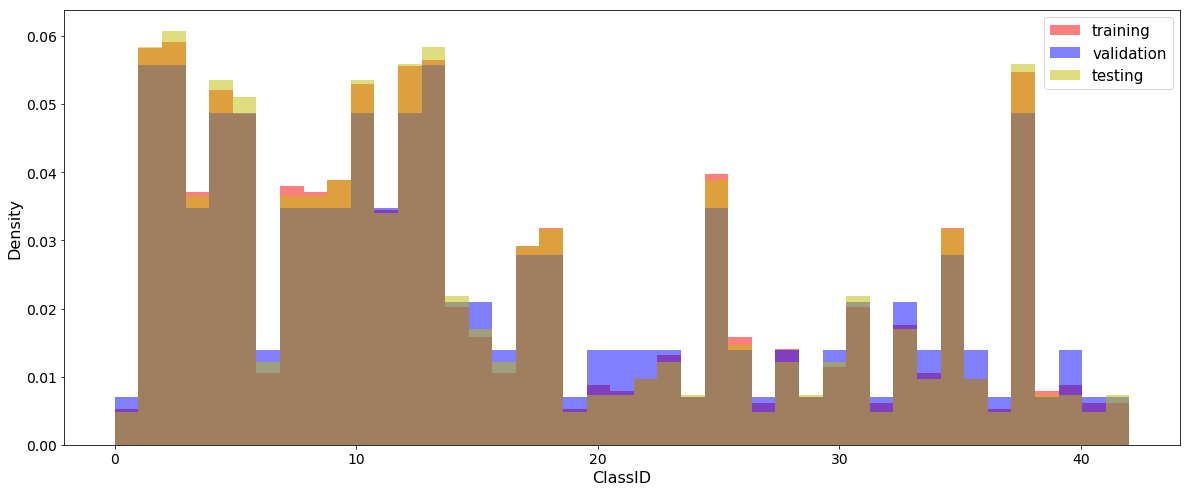

In [11]:
fig = plt.figure(figsize=(20, 8))

plt.hist(y_train, n_classes, histtype='stepfilled', facecolor='r', alpha=0.5, density=True, label='training')
plt.hist(y_valid, n_classes, histtype='stepfilled', facecolor='b', alpha=0.5, density=True, label='validation')
plt.hist(y_test, n_classes, histtype='stepfilled', facecolor='y', alpha=0.5, density=True, label='testing');
plt.xlabel("ClassID", fontsize=16)  
plt.ylabel("Density", fontsize=16)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)
plt.legend(fontsize=15);

The next figure displays sample images of the first five classes to get a feeling for the data. Important properties like brightness, background, perspective and size of the actual traffic sign vary widely between instances of the same class. To capture such varying conditions a machine learning approach is often the best approach.

Class: Speed limit (20km/h)   Classid: 0   Number of instances: 180


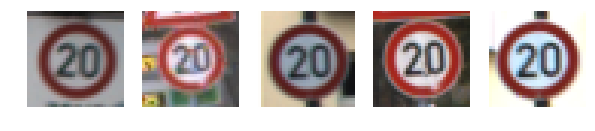

Class: Speed limit (30km/h)   Classid: 1   Number of instances: 1980


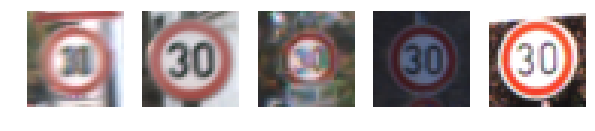

Class: Speed limit (50km/h)   Classid: 2   Number of instances: 2010


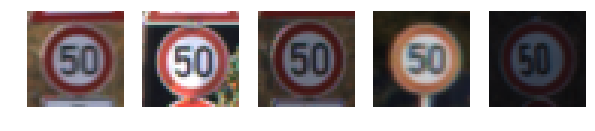

Class: Speed limit (60km/h)   Classid: 3   Number of instances: 1260


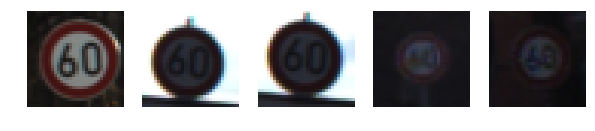

Class: Speed limit (70km/h)   Classid: 4   Number of instances: 1770


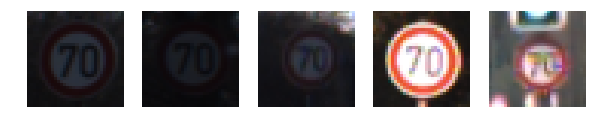

In [19]:
n_examples_per_class = 5

for cl in list(sign_names.keys())[:5]:  
    indices = (y_train == cl)
    no_current_class = len(X_train[indices])
    print('Class:', sign_names[cl], '  Classid:', cl, '  Number of instances:', no_current_class)
    fig = plt.figure(figsize = (10, 5))
    for idx, idx_img in enumerate(np.random.randint(0, no_current_class, n_examples_per_class)):
        ax = fig.add_subplot(1, n_examples_per_class, idx + 1)
        img = X_train[indices][idx_img]
        plt.axis('off')
        plt.imshow(img)    
    plt.show()   

## 3. Design and Test a Model Architecture

Before we can start training a couple of pre-processing steps are necessary to achieve a good performance on the test set. As discussed in the previous section the classes are imbalanced. Furthermore the total number of 34799 instances of the training set are not enough to train a flexible model which we intended to use. It would suffer from overfitting. We could either use a simpler model, regularize the model or increase the size of the training set.

The latter approach can be achieved with data augmentation (which also acts like a regularizer). We take the original images and apply randomly the following three transformations
* shift image
* zoom in center of image
* rotate image.

This enables us to artifically increase the size of training set. Furthmore we are also able to balance the classes.

Before feeding the data to our model we convert the images to grayscale and apply histogram equalization (image processing technique for increasing the contrast in an image). According to [YannLeCun](https://ieeexplore.ieee.org/document/6033589/f) this increases the performance of the model. We also normalize the intensity values of each pixel to a range between zero and one.

In [20]:
import cv2
from skimage import transform
import math
import random
import time


def grayscale(img):
    "Applies the Grayscale transform according to 0.299*R+0.587*G+0.114*B."
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


def pre_process(X, y=None, augment=False, uniform=False, factor=1):
    if uniform:
        return pre_process_uniform(X, y, factor)
    else:
        return pre_process_original(X, y, augment, factor)
       
       
def pre_process_uniform(X, y, factor=1):
    """Preprocess images: grayscale, normalize and reshape.
    
    Args:
    X     -- data set with format (m, width, height, 3)
    """
    assert len(X.shape)==4
    assert y is not None
    
    _, width, height, channels = X.shape
    X = [grayscale(image) for image in X]
    # apply histogram equalization (image processing technique to improve contrast)
    clahe = cv2.createCLAHE(tileGridSize=(2,2), clipLimit=20.0)
    X = [clahe.apply(image) for image in X]
    # apply augmentation and create uniform distribution
    no_classes = 43
    instances_per_class = int(len(X)*factor)//no_classes
    Xtmp, ytmp = [], []
    for cl in range(no_classes): 
        index = (y == cl)
        index = np.where(index==True)
        indices = np.random.choice(index[0], size=instances_per_class, replace=True)
        for i in indices:
            Xtmp.append(X[i])
        ytmp = ytmp + [cl]*instances_per_class
    X = [augmentation(image) for image in Xtmp] # for _ in range(factor) 
    # input node of tensorflow graph expects inputs of shape (None, x_dim, y_dim, channels)
    # in case of grayscale image one has to add the last dimension with channels=1ytmp
    X = [image.reshape(width, height, 1) for image in X]
    return np.array(X, dtype=np.float32), np.array(ytmp, dtype=np.uint8)


def pre_process_original(X, y=None, augment=False, factor=1):
    """Preprocess images: grayscale, normalize and reshape.
    
    Args:
    X     -- data set with format (m, width, height, 3)
    """
    assert len(X.shape)==4, str(X.shape)
    
    _, width, height, channels = X.shape
    X = [grayscale(image) for image in X]
    # apply histogram equalization (image processing technique to improve contrast)
    clahe = cv2.createCLAHE(tileGridSize=(2,2), clipLimit=20.0)
    X = [clahe.apply(image) for image in X]
    # apply augmentation
    if augment:
        X = [augmentation(image) for _ in range(factor) for image in X]
        y = [label for _ in range(factor) for label in y]
    else:
        # necessary to normalize image: otherwise normalization is done by transform.rotate 
        X = [image / 255. for image in X]
    # input node of tensorflow graph expects inputs of shape (None, x_dim, y_dim, channels)
    # in case of grayscale image one has to add the last dimension with channels=1
    X = [image.reshape(width, height, 1) for image in X]
    if y is not None:
        return np.array(X, dtype=np.float32), np.array(y, dtype=np.uint8)
    return np.array(X, dtype=np.float32)
    

def augmentation(image, max_shift = 2, max_angle = 10, max_zoom = 2):
    """Shift, rotate and zoom randomly. Used for data augmentation.
    
    Args:
    image     -- original image
    max_shift -- image is shifted randomly by pixels in range [-max_shift, max_shift]
    max_angle -- rotate image randomly by angle in range [-max_angle, max_angle]
    max_zoom  -- zoom randomly by a number of pixels in range [0, max_zoom]
    """
    width_initial, height_inital = image.shape[:2]
            
    # rotate image by an  randomly choosen angle between [-max_angle, max_angle]
    # automatic normalization to [0:1]
    angle = random.uniform(-max_angle, max_angle)
    image = transform.rotate(image, angle, mode = 'edge', preserve_range=False)
    
    # zoom randomly by shrinking the image (without changing the center position of the traffic sign)
    # and resizing it to its original size
    pixel_shrink = np.random.randint(0, max_zoom + 1)
    x0 = pixel_shrink
    y0 = pixel_shrink
    x1 = width_initial - pixel_shrink
    y1 = height_inital - pixel_shrink
    image = image[y0:y1, x0:x1]
    image = transform.resize(image, (width_initial, height_inital), mode='reflect')
    # shift image randomly in horizontal and vertical direction 
    pixel_shift_ver = np.random.randint(-max_shift, max_shift + 1)
    pixel_shift_hor = np.random.randint(-max_shift, max_shift + 1)
    x0, x1 = bounding_box_shift(pixel_shift_ver, width_initial)
    y0, y1 = bounding_box_shift(pixel_shift_hor, height_inital)
    image = image[y0:y1, x0:x1]
    image = transform.resize(image, (width_initial, height_inital), mode='reflect')
        
    return image


def bounding_box_shift(pixel_shift, dim_initial):
    """Compute coordinates to shift image.transform
    
    Args:
    pixel_shift -- shift in pixels
    dim_initial -- size of original image in direction of shift
    """
    if pixel_shift < 0:
        return abs(pixel_shift), dim_initial
    else:
        return 0, dim_initial- pixel_shift
    return 0, dim_initial


We present here an example for an image of class *Speed limit (30km/h)* for which we created five copies through data augmentation. Each copy has slightly different properties. 

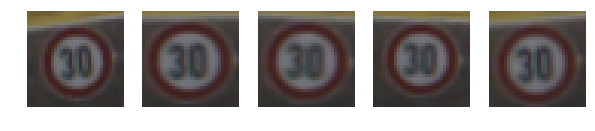

In [21]:
imgo = X_train[2800]
img_aug = [augmentation(imgo) for _ in range(5)]

fig = plt.figure(figsize = (10, 5))
for idx, img in enumerate(img_aug):
    ax = fig.add_subplot(1, len(img_aug), idx + 1)
    plt.axis('off')
    img = img.reshape((32, 32, 3))
    plt.imshow(img)    
plt.show()

After the pre-processing steps we can proceed and decide upon the architecture of our CNN-model. We chose an architecture which strongly resembles the architecture of [YannLeCun](https://ieeexplore.ieee.org/document/6033589/f). We have three CNN-layers separated by max-pooling layers and a fully connected layer and a softmax-output layer being part of the classifier stage (see next figure which was taken from [YannLeCun](https://ieeexplore.ieee.org/document/6033589/f)). Furthermore we use dropout to regularize all three CNN-layers and the fully-connected layer. In addition the fully-connected layer is also regularized with an _l2_-penalty term.

![alt text](./images/yanlecun_architecture_cnn.png)

The *prepare_batch* function is intended for mini-batch processing. In conventional mini-batch the entire training data set is shuffeled and then divided in $n$ mini-batches. Training is done for each of these mini-batches. In contrast *prepare_batch* shuffels the data again for each mini-batch. In principle it could happen that we accidently obtain each time the same mini-batch. However in practice the difference between convential mini-batch and our method is tiny (and the implementation of our method is shorter).

In [22]:
from sklearn.utils import shuffle


def prepare_batch(X, y, batch_size):
    """Return a batch of given size with data augmentation.
    
    Note: This is actually no real mini-batch implementation.
    In principle the function might return for each call the same data set.
    However, in practice the difference between real mini-batch and this implementation
    is minor.
    
    Image is always normalized to range [0:1].
    
    Args:
    X            -- data set of images
    y            -- class labels
    batch_size   -- batch_size of batch
    """
    Xs, ys = shuffle(X, y)
    return Xs[:batch_size], ys[:batch_size]
    

def status(n_epochs, n_batches):
    """Return function which returns string with status information (e.g. remaining time)"""
    status.time_tot = 0
    status.curr_iter = 0
    status.n_batches = n_batches
    status.n_epochs = n_epochs
    status.n_iter = n_batches*n_epochs
    def _f(time_diff, epoch, batch):
        status.time_tot = status.time_tot + time_diff
        status.curr_iter = status.curr_iter + 1
        mean_time_per_batch = status.time_tot/status.curr_iter
        str_out = "Epochs: %s/%s \tIterations: %s/%s \tTime per batch: %s s \tRemaining time: %s s" % (
                    epoch, status.n_epochs, 
                    status.curr_iter, status.n_iter, 
                    round(mean_time_per_batch, 4),
                    round((status.n_iter - status.curr_iter)*mean_time_per_batch, 4))
        return str_out
    return _f    

The next table summarizes the parameters of our model. For some parameters we give two values. Later we train the model with each possible parameter combination and pick the one having the best performance on the validation test.

parameter          | value 
--------------     | --------------
learning_rate      | 0.001 
batch_size         | 512
n_neuron_class     | [512, 1024]
reg_rate           | [0.0001, 0.001]
dropout_rate_cnn   | [0.1, 0.2]
dropout_rate_class | [0, 0.5]
activation func    | tf.nn.relu
no_filters_1       | 32
no_filters_2       | 64
no_filters_3       | 128
ksize              | 5
strides            | 1
padding            | "SAME"
size_pool          | 2
strides_pool       | 2
padding_pool       | "SAME"

Our model exhibits the typically funnel shape found with many CNN architectures: Decreasing width and height but increasing depth i.e. number of feature maps. The kernel size, stride and padding is for all CNN-layers and for all max-pooling layers the same. 

Our model has  the option to feed the output of the first and second CNN-layer - after an additonal max-pooling layer - directly to the classifier. This method enabled [YannLeCun](https://ieeexplore.ieee.org/document/6033589/f) to improve its performance on the test set significantly. The classifier is able to use high-level and low-level features for training.

Our implementation has some additional features:
* it uses early stopping to mitigate the effect of over-fitting. After 20 epochs without improvement of the loss on the validation set the optimization algorithm stops and the weights with the smallest loss are picked as result of the optimization process
* we save regular checkpoints of the weights of the model. This comes in handy if training is interrupted
* we save performance metrics accuracy and loss for each epoch using special nodes provided by tensorflow
* we use the Adam optimizer instead of plain gradient descent
* the results of the model fit are saved to disk after training

In [23]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError 
import time
from datetime import datetime
import os

tf.reset_default_graph() 

class CNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, optimizer_class=tf.train.AdamOptimizer,
                 activation=tf.nn.relu, n_neuron_class=1024,
                 batch_size=256,
                 learning_rate=0.001, reg_rate=0.0001,
                 initializer=tf.contrib.layers.variance_scaling_initializer(),
                 concate=True,
                 dropout_rate_cnn=None, dropout_rate_class=None, 
                 random_state=None,
                 checkpoint_path='./tmp/',
                 final_model_path='./my_model',
                 restore_model_path=None
                ):
        """Initialize the CNNClassifier by simply storing all the hyperparameters."""
        self.optimizer_class = optimizer_class
        self.activation = activation
        self.n_neuron_class = n_neuron_class
        self.batch_size = batch_size
        self.learning_rate = learning_rate 
        self.reg_rate = reg_rate
        self.initializer = initializer
        self.concate = concate
        self.dropout_rate_cnn = dropout_rate_cnn
        self.dropout_rate_class = dropout_rate_class
        self.random_state = random_state
        self._checkpoint_path = checkpoint_path
        self._checkpoint_epoch_path = self._checkpoint_path + '.epoch'
        self._final_model_path = final_model_path
        self._restore_model_path = restore_model_path
        self._session = None

        
    def _cnn(self, inputs): 
        """Build the actual CNN."""
        with tf.name_scope('conv_layers'):
            # input: 32x32x1  
            # layer: 30x30x32
            out = tf.layers.conv2d(inputs, filters=32, kernel_size=5, 
                                   strides=[1, 1], padding="SAME", 
                                   activation=self.activation, name='conv_layer1')
            # layer: 15x15x32
            out = tf.nn.max_pool(out,
                                 ksize=[1, 2, 2, 1],
                                 strides=[1, 2, 2, 1],
                                 padding='SAME',
                                 name='pooling_layer1')
            if self.dropout_rate_cnn:
                out = tf.layers.dropout(out, self.dropout_rate_cnn, training=self._training, name='dropout1')
            # feed this output to classifier after another max-pooling step
            out_stage1 = tf.nn.max_pool(out,
                                       ksize=[1, 2, 2, 1],
                                       strides=[1, 2, 2, 1],
                                       padding='SAME',
                                       name='pooling_stage1')
            
            # layer: 13x13x64
            out = tf.layers.conv2d(out, filters=64, kernel_size=5, 
                                   strides=[1, 1], padding="SAME", 
                                   activation=self.activation, name='conv_layer2')  
            # layer: 6x6x64
            out = tf.nn.max_pool(out,
                                 ksize=[1, 2, 2, 1],
                                 strides=[1, 2, 2, 1],
                                 padding='SAME',
                                 name='pooling_layer2')
            if self.dropout_rate_cnn:
                out = tf.layers.dropout(out, self.dropout_rate_cnn, training=self._training, name='dropout2')
            # feed this output to classifier after another max-pooling step
            out_stage2 = tf.nn.max_pool(out,
                                       ksize=[1, 2, 2, 1],
                                       strides=[1, 2, 2, 1],
                                       padding='SAME',
                                       name='pooling_stage1')

            
            # layer: 4x4x128            
            out = tf.layers.conv2d(out, filters=128, kernel_size=5, 
                                   strides=[1, 1], padding="SAME", 
                                   activation=self.activation, name='conv_layer3') 
            # layer: 2x2x128
            out = tf.nn.max_pool(out,
                                 ksize=[1, 2, 2, 1],
                                 strides=[1, 2, 2, 1],
                                 padding='SAME',
                                 name='pooling_layer3')
            if self.dropout_rate_cnn:
                out = tf.layers.dropout(out, self.dropout_rate_cnn, training=self._training, name='dropout3')
            # reshape out in a tensor of shape (m, n_neurons_layer, 1)
            m, h, w, d = out.get_shape()
            out = tf.reshape(out, [-1, h*w*d])   # 512 neurons
            # reshape first stage output
            m, h, w, d = out_stage1.get_shape()
            out_stage1 = tf.reshape(out_stage1, [-1, h*w*d])
            # reshape second stage output
            m, h, w, d = out_stage2.get_shape()
            out_stage2 = tf.reshape(out_stage2, [-1, h*w*d])
            # concatenate all outputs
            if self.concate:
                out = tf.concat([out_stage1, out_stage2, out], 1)
        with tf.name_scope('classifier'):
            out = tf.layers.dense(out, self.n_neuron_class, activation=self.activation, 
                                  kernel_regularizer=tf.contrib.layers.l2_regularizer(self.reg_rate),
                                  name='fully_connected')
            if self.dropout_rate_class:
                out = tf.layers.dropout(out, self.dropout_rate_class, training=self._training, name='dropout4')
       
        return out
    
    def _build_graph(self, width, height, channels, n_outputs):
        """Build graph of model.
        
        Important nodes which are evaluated later on are assigned to private instance variables for easy access
        by other methods.
        """
        if self.random_state is not None: 
            tf.set_random_seed(self.random_state) 
            np.random.seed(self.random_state)
            
        X = tf.placeholder(tf.float32, shape=(None, height, width, channels), name='X')
        y = tf.placeholder(tf.int64, shape=(None), name='y')
        
        # set training variable for controlling dropout
        if self.dropout_rate_cnn or self.dropout_rate_class:
            self._training = tf.placeholder_with_default(False, shape=(), name='training') 
        else:
            self._training = None 
        
        with tf.variable_scope("cnn"):
            cnn = self._cnn(X)
            logits = tf.layers.dense(cnn, n_outputs, kernel_initializer=self.initializer, name="logits")
            Y_proba = tf.nn.softmax(logits, name="Y_proba")
        with tf.name_scope("train"):
            # it is at this point where we get a relationship between a class label and a neuron of the output layer
            # y has to be in range: [0, no_classes-1]
            # before this step no output neuron is assigned to a class
            xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
            base_loss = tf.reduce_mean(xentropy, name='base_loss')
            # reg loss:
            reg_loss = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
            loss = tf.add_n([base_loss] + reg_loss, name='loss')
            loss_summary = tf.summary.scalar('loss_summary', loss)
            optimizer = self.optimizer_class(learning_rate=self.learning_rate)
            training_op = optimizer.minimize(loss, name='training_op')
        with tf.name_scope("eval"):
            y_pred = tf.nn.in_top_k(logits, y, 1)
            accuracy = tf.reduce_mean(tf.cast(y_pred, tf.float32), name='accuracy')
            accuracy_summary = tf.summary.scalar('accuracy_summary', accuracy)
        with tf.name_scope("init"):
            init = tf.global_variables_initializer()
        with tf.name_scope("saver"):
            saver = tf.train.Saver()                          

        self._X, self._y = X, y
        self._loss, self._Y_proba = loss, Y_proba
        self._accuracy, self._training_op = accuracy, training_op
        self._init, self._saver = init, saver
        self._loss_summary = loss_summary
        self._accuracy_summary = accuracy_summary
        self._file_writer = tf.summary.FileWriter(self._log_dir("traffic_sign_class"), tf.get_default_graph())
        
    def _log_dir(self, prefix=""):
        now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
        root_logdir = "tf_logs"
        if prefix:
            prefix += "-"
        name = prefix + "run-" + now
        return "{}/{}/".format(root_logdir, name)
        
    def close_session(self):
        if self._session:
            self._session.close_session()
                
    def _get_model_params(self):
        """Get all variable values (used for early stopping, faster than saving to disk)"""
        with self._graph.as_default():
            gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        return {gvar.op.name : value for gvar, value in zip(gvars, self._session.run(gvars))}
        
    def _restore_model_params(self, model_params):
        """Set all variables to the given values (for early stopping, faster than loading from disk).
        
        model_params is a dictonary which contians values for alle tf.Variable operations of graph.
        Function assigns these values to all variables.
        
        Args:
        model_params -- Dictonary as return by _get_model_params {op_name : value, ...}
        """
        op_names = list(model_params.keys())
        # first we need a handle the assignment operations of all tf.Variables
        op_handles = {op_name : self._graph.get_operation_by_name(op_name + '/Assign') for op_name in op_names}
        # next we need a handle on the second Input of these assignment operation
        op_input_handles = {op_name : op_handle.inputs[1] for op_name, op_handle in op_handles.items()}
        # lastly, we setup the feed_dict we pass to the run operation
        feed_dict = {op_input_handles[op_name] : model_params[op_name]   for op_name in op_names}
        # you can pass a dict to run (evaluates automatically the values). Here a list of operations
        # would have been sufficient as well. Note: You have to run the Assignment-Node not its second input.
        self._session.run(op_handles, feed_dict=feed_dict)         
        
    def fit(self, X, y, n_epochs=10, X_valid=None, y_valid=None):
        """Fit the model to the training set. If X_valid and y_valid are provided, use early stopping.
        
        Args: 
        X  -- training set in format (m, width, height, channels)
        y  -- labels
        n_epochs -- number of epochs
        X_valid -- validation set (m, width, height, channels)
        y_valid -- labels of validation set
        """
        
        self.close_session()
        
        # convert class labels of y to contigous index in range [0, no_classes-1]
        # self.classes is a lookup table to restore the original y
        self.classes_, y = np.unique(y, return_inverse=True)
        
        # infer number of input and output neurons from data
        _, width, height, channels = X.shape
        n_outputs = len(self.classes_)
        
        # build graph 
        self._graph = tf.Graph()
        with self._graph.as_default():
            self._build_graph(width, height, channels, n_outputs)
        
        # variables which are needed in case of early stopping
        max_checks_without_progress = 20
        checks_without_progress = 0
        best_loss = np.infty
        best_params = None  
        
        # start the actual training of the model
        # start session and select graph to run
        self._session = tf.Session(graph=self._graph)
        with self._session.as_default() as sess:
            if os.path.isfile(self._checkpoint_epoch_path):
                # if the checkpoint file exists, restore the model and load the epoch number
                with open(self._checkpoint_epoch_path, "rb") as f:
                    start_epoch = int(f.read())
                print("Training was interrupted. Continuing at epoch", start_epoch)
                self._saver.restore(sess, self._checkpoint_path)       
            elif self._restore_model_path is not None:
                self._saver.restore(sess, self._restore_model_path) 
                print("Restore existing model.")
                if n_epochs==0:
                    return self
            else:
                start_epoch = 0
                self._init.run()           
            
            n_batches = (len(X) // self.batch_size)
            str_status = status(n_epochs, n_batches)
            for epoch in range(start_epoch, n_epochs):    
                t0e = time.time()
                for i in range(n_batches):
                    t0 = time.time()
                    X_batch, y_batch = prepare_batch(X, y, self.batch_size) 
                    feed_dict = {self._X: X_batch, self._y: y_batch}
                    if self._training is not None:
                        feed_dict[self._training] = True
                    sess.run(self._training_op, feed_dict=feed_dict)
                    t1 = time.time()
                    print('\r' + str_status(t1-t0, epoch, i), end="")
                # early stopping if X_valid and y_valid are given
                if (X_valid is not None) and (y_valid is not None):
                    #loss_valid, acc_valid, loss_summary_str, accuracy_summary_str = 
                    #    self.loss_and_accuracy(X_valid, y_valid, batch_size=256)
                    loss_valid, acc_valid, loss_summary_str, accuracy_summary_str = sess.run([self._loss, self._accuracy, 
                                                         self._loss_summary, self._accuracy_summary], 
                                                         feed_dict={self._X: X_valid_pre, self._y : y_valid}) 
                    if best_loss > loss_valid:
                        checks_without_progress = 0
                        best_loss = loss_valid
                        best_params = self._get_model_params()
                    else:
                        if checks_without_progress > max_checks_without_progress:
                            print()
                            print('Early stopping!')
                            break
                        checks_without_progress += 1
                    print()
                    print(epoch, '\tloss_valid:', loss_valid, '\tbest_loss:', best_loss, '\tacc_valid', acc_valid)
                else:
                    loss_train, acc_train, loss_summary_str, accuracy_summary_str = sess.run([self._loss, self._accuracy, 
                                                         self._loss_summary, self._accuracy_summary], 
                                                         feed_dict={self._X: X_batch, self._y : y_batch}) 
                    print()
                    print(epoch, '\tLast training batch loss:', loss_train, 
                          '\tLast training batch accuracy', acc_train)
                t1e = time.time()
                print("Time per epoch: %s s"  % (round(t1e-t0e, 4)))
                # write learning curves every epoch
                self._file_writer.add_summary(loss_summary_str, epoch)
                self._file_writer.add_summary(accuracy_summary_str, epoch)
                # save model every tens epoch in case of a computer crash
                if epoch % 10 == 0:
                    self._saver.save(sess, self._checkpoint_path)
                    with open(self._checkpoint_epoch_path, "wb") as f:
                        f.write(b"%d" % (epoch + 1))
            # in case of early stopping: restore parameters of winner snapshot
            if best_params is not None:
                self._restore_model_params(best_params)  
            os.remove(self._checkpoint_epoch_path)
            # save final model
            self._saver.save(sess, self._final_model_path)    
                
            return self    
                       
    def predict_proba(self, X):
        # self._session has only a value if fit method has been run   
        if not self._session:
            raise NotFittedError('Fit method of this instance has not yet been run.')
        # no need to pass self._training = False because this is the default value
        # self._X is a handle on the placeholder node of X
        return self._session.run(self._Y_proba, feed_dict = {self._X: X})

    def predict(self, X, test_batch_size=200):
        class_indices = np.argmax(self.predict_proba(X), axis=1)
        # self.classes_ is just a lookup table to get the class label for the index 
        # in the contiguous range [0, no_classes-1]
        # predict is supposed to return an array according to sklearn convention
        return np.array([self.classes_[class_idx] 
                         for class_idx in class_indices], np.int32)
    
    def loss_and_accuracy(self, X, y, batch_size=256):
        """Compute loss and accuracy for each batch and average the results.  
        
        Useful if X is very large.
        
        Args:
        X          -- full data set
        y          -- labels
        batch_size -- size of each batch
        """
        if not self._session:
            raise NotFittedError('Fit method of this instance has not yet been run.')
             
        n_batch_size = len(X) // batch_size
        X_batches = np.array_split(X, n_batch_size)
        y_batches = np.array_split(y, n_batch_size)
        results = [ self._session.run([self._loss, self._accuracy], 
                             feed_dict={self._X: X_batch, self._y: y_batch})
                    for X_batch, y_batch in zip(X_batches, y_batches) ]
        results = np.mean(results, axis=0)
                
        return results[0], results[1]
            
    def save(self, path):
        """Save all tf.Variable operations of session to disk."""
        self._saver.save(self._session, path)

Our entire model is implemented as a class *CNNClassifier* which is a subclass of *BaseEstimator* and *ClassifierMixing*. It conforms to the *sklearn* interface because we originally intended to use *RandomizedSearchCV* to search the parameter space for the best possible combination (see commented code cell below).  

In [ ]:
#from sklearn.model_selection import RandomizedSearchCV

#rnd_search = RandomizedSearchCV(CNNClassifier(batch_size=512, learning_rate=0.001), 
#                                param_distribs, n_iter=1, cv=3,
#                                fit_params={"X_valid": X_valid_pre, "y_valid": y_validd},
#                                dverbose=2)
#rnd_search.fit(X_train_pre, y_train)
#rnd_search.fit(X_train_pre, y_train, X_valid=X_valid_pre, y_valid=y_valid, n_epochs=500)  

Unfortunately *RandomizedSearchCV* does not seem to clear its occupied space in memory after each iteration resulting in an out-of-memory error after some iterations. We decided to perform grid search with a limited set of parameters and a simple for loop.

In [ ]:
X_train_pre, y_train_pre = pre_process(X_train, y_train, augment=True, uniform=True, factor=2)
X_valid_pre = pre_process(X_valid, augment=False, uniform=False)

param_distribs = {
    "n_neuron_class": [512, 1024],
    "reg_rate": [0.0001, 0.001],
    "concate": [True, False],
    "dropout_rate_cnn": [0.1, 0.2]
}

for n_neuron_class in param_distribs["n_neuron_class"]: 
    for reg_rate in param_distribs["reg_rate"]: 
        for concate in param_distribs["concate"]: 
            for dropout_rate_cnn in param_distribs["dropout_rate_cnn"]:
                print()
                print("n_neuron_class:", n_neuron_class, "\treg_rate:", reg_rate,
                      "\tconcate:", concate, "\tdropout_rate_cnn:", dropout_rate_cnn)
                dnn_clf = CNNClassifier(batch_size=512, 
                                        learning_rate=0.001,
                                        n_neuron_class=n_neuron_class,
                                        reg_rate=reg_rate,
                                        concate=concate,
                                        dropout_rate_cnn=dropout_rate_cnn,
                                        dropout_rate_class=0.5)
                dnn_clf.fit(X_train_pre, y_train_pre, 500, X_valid_pre, y_valid)
                print('training:', dnn_clf.loss_and_accuracy(X_train_pre, y_train_pre))  
                print('validation:', dnn_clf.loss_and_accuracy(X_valid_pre, y_valid))

In total we fitted 32 different models to a training set twice as large as the orginal training set and with balanced classes. We varied the parameters *n_neuron_class*, *reg_rate*, *concate*, *dropout_rate_cnn* and *dropout_rate_class*. *concate=True* refers to the case if the output of the first and second CNN-layer are feed directly to the classifier.
The next table summarizes the findings. For each model it documents the loss on the training and validation sets and the accuracies.

index | n_neuron_class | reg_rate | concate | dropout_rate_cnn | dropout_rate_class | loss_train | acc_train | loss_val | acc_val
 -------|-------|-------|-------| ------- |-------|-------|-------| ------- | -------
    1    | 512  | 0.0001 | True  | 0.1 | 0   | 0.0198  | 0.9998 | 0.1012 | 0.9798
    2    | 512  | 0.0001 | True  | 0.2 | 0   |  0.0267 | 0.9996 | 0.1269 | 0.9750 
    3    | 512  | 0.0001 | False | 0.1 | 0   |  0.0154 | 0.9998 | 0.1626 | 0.9696
    4    | 512  | 0.0001 | False | 0.2 | 0   |  0.0224 | 0.9999 | 0.1452 | 0.9739
    5    | 512  | 0.001  | True  | 0.1 | 0   |  0.0243 | 0.9994 | 0.0967 | 0.9807
    6    | 512  | 0.001  | True  | 0.2 | 0   |  0.0289 | 0.9999 | 0.0954 | 0.9818
    7    | 512  | 0.001  | False | 0.1 | 0   |  0.0194 | 0.9999 | 0.1038 | 0.9766
    8    | 512  | 0.001  | False | 0.2 | 0   |  0.0367 | 0.9999 | 0.1267 | 0.9742
    9    | 1024 | 0.0001 | True  | 0.1 | 0   |  0.0345 | 0.9994 | 0.1757 | 0.9655
   10    | 1024 | 0.0001 | True  | 0.2 | 0   |  0.0379 | 0.9999 | 0.1843 | 0.9648
   11    | 1024 | 0.0001 | False | 0.1 | 0   |  0.0226 | 0.9993 | 0.1342 | 0.9743
   12    | 1024 | 0.0001 | False | 0.2 | 0   |  0.0285 | 0.9999 | 0.1818 | 0.9712
   13    | 1024 | 0.001  | True  | 0.1 | 0   |  0.0204 | 0.9999 | 0.1076 | 0.9812
   14    | 1024 | 0.001  | True  | 0.2 | 0   |  0.0289 | 0.9999 | 0.1003 | 0.9803
   15    | 1024 | 0.001  | False | 0.1 | 0   |  0.0190 | 0.9999 | 0.1058 | 0.9807 
   16    | 1024 | 0.001  | False | 0.2 | 0   |  0.0301 | 1      | 0.1186 | 0.9784
    1    | 512  | 0.0001 | True  | 0.1 | 0.5 |  0.0324 | 0.9999 | 0.1095 | 0.9823
    2    | 512  | 0.0001 | True  | 0.2 | 0.5 |  0.0428 | 0.9999 | 0.1128 | 0.9821 
    3    | 512  | 0.0001 | False | 0.1 | 0.5 |  0.0216 | 0.9999 | 0.1526 | 0.9760
    4    | 512  | 0.0001 | False | 0.2 | 0.5 |  0.0280 | 0.9999 | 0.1080 | 0.9823
    5    | 512  | 0.001  | True  | 0.1 | 0.5 |  0.0472 | 0.9999 | 0.1061 | 0.9866
    6    | 512  | 0.001  | True  | 0.2 | 0.5 |  0.0603 | 0.9999 | 0.1052 | 0.9882
    7    | 512  | 0.001  | False | 0.1 | 0.5 |  0.0271 | 1      | 0.1019 | 0.9821
    8    | 512  | 0.001  | False | 0.2 | 0.5 |  0.0541 | 0.9998 | 0.1123 | 0.9852
    9    | 1024 | 0.0001 | True  | 0.1 | 0.5 |  0.0412 | 1      | 0.1190 | 0.9818
   10    | 1024 | 0.0001 | True  | 0.2 | 0.5 |  0.0537 | 0.9999 | 0.1323 | 0.9787
   11    | 1024 | 0.0001 | False | 0.1 | 0.5 |  0.0249 | 0.9999 | 0.1109 | 0.9796
   12    | 1024 | 0.0001 | False | 0.2 | 0.5 |  0.0387 | 0.9999 | 0.1230 | 0.9798
   13    | 1024 | 0.001  | True  | 0.1 | 0.5 |  0.0660 | 0.9997 | 0.1140 | 0.9850
   14    | 1024 | 0.001  | True  | 0.2 | 0.5 |  0.0771 | 0.9997 | 0.1123 | 0.9884
   15    | 1024 | 0.001  | False | 0.1 | 0.5 |  0.0428 | 0.9999 | 0.1094 | 0.9825 
   16    | 1024 | 0.001  | False | 0.2 | 0.5 |  0.0600 | 0.9999 | 0.1110 | 0.9850

The following plots show the content of the table in visuale form. The first thing one notices when looking either at the table or the plots is that our model strongly overfitts the training data. The accuracy on the training set is close to 100% while the accuracy on the validation set is between 98% and 99%. This puts a question mark behind our procedure (i.e. fitting a large number of models and picking the one with the smallest validation error) because it doesn't make that much sense to compare 32 models which all overfit the data.

It would be necessary to use a much larger data set which is probably at least 10 or 20 times larger than the original training set. However training all these models on aws which such a larger training set would be too costly. 

Neverthless we picked the model with the best performance on the validation set despite the uncertainty that the model which has the smallest validation loss on a training set twice the size of the original training set would also have the smallest validation loss on a data set twenty times as large as the training set. Its parameters are:
* n_neuron_class=1024
* concate=True
* reg_rate=0.001
* dropout_rate_cnn=0.1
* dropout_rate_class=0.5

In [24]:
x = np.concatenate((np.linspace(1, 16, 16), np.linspace(1, 16, 16)))
y = np.array([0.9798, 0.9750, 0.9696, 0.9739, 0.9807, 0.9818, 0.9766, 0.9742, 0.9655, 0.9648, 
              0.9743, 0.9712, 0.9812, 0.9803, 0.9807, 0.9784, 0.9823, 0.9821, 0.9760, 0.9823,
              0.9866, 0.9882, 0.9821, 0.9852, 0.9818, 0.9787, 0.9796, 0.9798, 0.9850, 0.9884,
              0.9825, 0.9850])
dropout_rate_class = np.concatenate((np.repeat(0.0, 16), np.repeat(0.5, 16)))
dropout_rate_cnn = np.array([0.1, 0.2, 0.1, 0.2, 0.1, 0.2, 0.1, 0.2,
                             0.1, 0.2, 0.1, 0.2, 0.1, 0.2, 0.1, 0.2,
                             0.1, 0.2, 0.1, 0.2, 0.1, 0.2, 0.1, 0.2,
                             0.1, 0.2, 0.1, 0.2, 0.1, 0.2, 0.1, 0.2])
concate = np.array([True, True, False, False, True, True, False, False, 
                    True, True, False, False, True, True, False, False,
                    True, True, False, False, True, True, False, False,
                    True, True, False, False, True, True, False, False])
n_neuron_class = np.concatenate((np.repeat(512, 8), np.repeat(1024, 8), np.repeat(512, 8), np.repeat(1024, 8)))
reg_rate = np.array([0.0001, 0.0001, 0.0001, 0.0001, 0.001, 0.001, 0.001, 0.001,
                     0.0001, 0.0001, 0.0001, 0.0001, 0.001, 0.001, 0.001, 0.001,
                     0.0001, 0.0001, 0.0001, 0.0001, 0.001, 0.001, 0.001, 0.001,
                     0.0001, 0.0001, 0.0001, 0.0001, 0.001, 0.001, 0.001, 0.001])

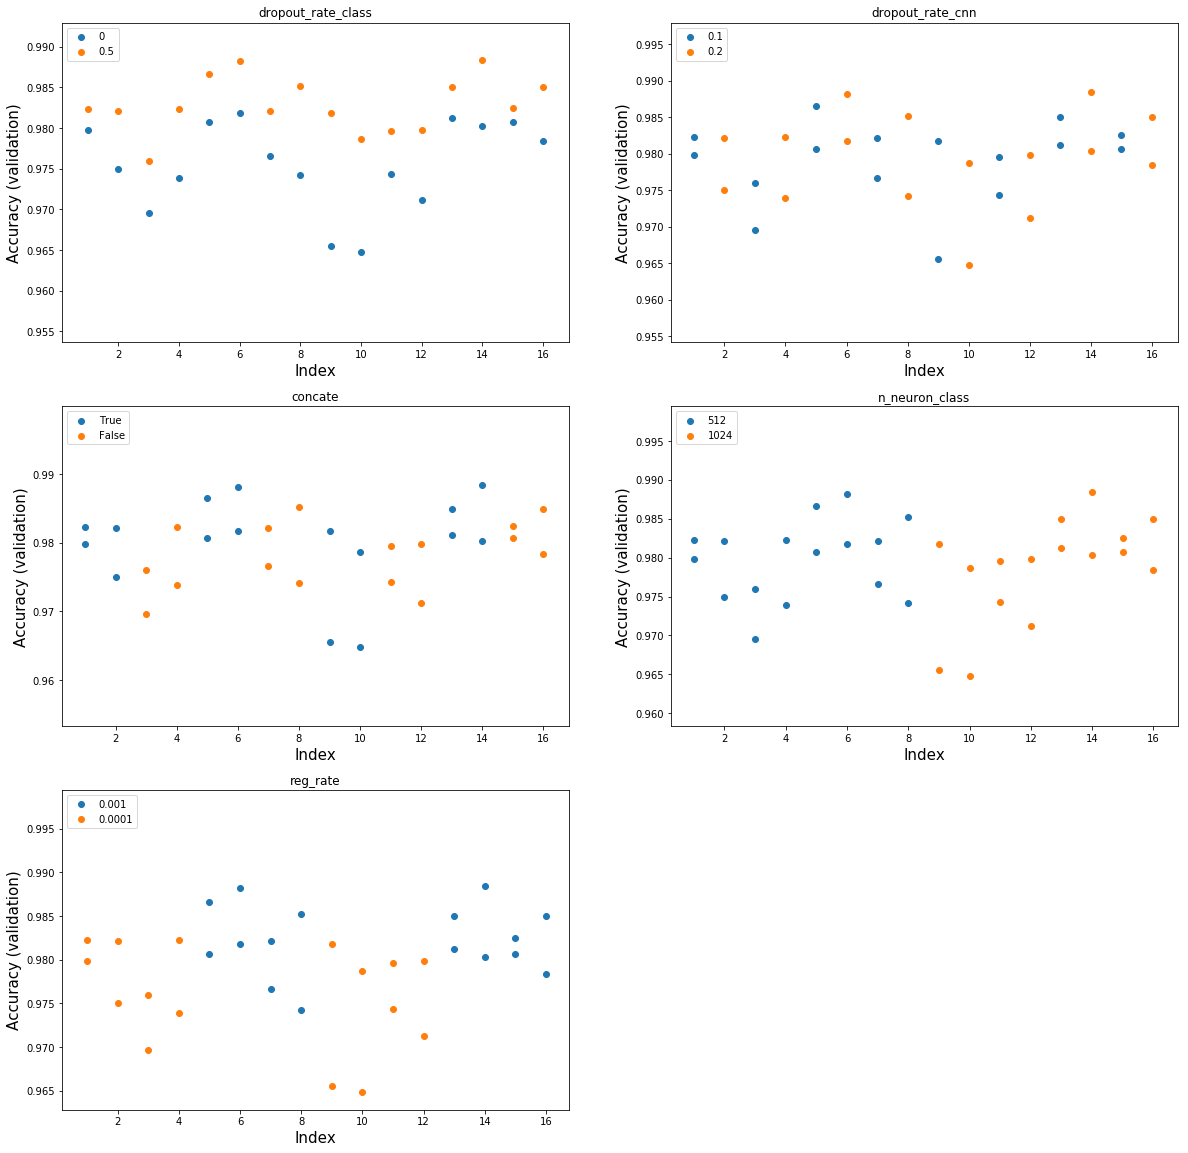

In [25]:
import matplotlib.patches as mpatches

fig = plt.figure(figsize=(20, 20))

# plot 1
ax = fig.add_subplot(3, 2, 1)
plt.scatter(x[dropout_rate_class==0], y[dropout_rate_class==0], label="0")
plt.scatter(x[dropout_rate_class==0.5], y[dropout_rate_class==0.5], label="0.5")
plt.xlabel("Index", fontsize=15)  
plt.ylabel("Accuracy (validation)", fontsize=15)
plt.title("dropout_rate_class")
plt.legend(loc=2)
# plot 2
ax = fig.add_subplot(3, 2, 2)
plt.scatter(x[dropout_rate_cnn==0.1], y[dropout_rate_cnn==0.1], label="0.1")
plt.scatter(x[dropout_rate_cnn==0.2], y[dropout_rate_cnn==0.2], label="0.2")
plt.xlabel("Index", fontsize=15)  
plt.ylabel("Accuracy (validation)", fontsize=15)
plt.title("dropout_rate_cnn")
plt.legend(loc=2)
# plot 3
ax = fig.add_subplot(3, 2, 3)
plt.scatter(x[concate==True], y[concate==True], label="True")
plt.scatter(x[concate==False], y[concate==False], label="False")
plt.xlabel("Index", fontsize=15)  
plt.ylabel("Accuracy (validation)", fontsize=15)
plt.title("concate")
plt.legend(loc=2)
# plot 4
ax = fig.add_subplot(3, 2, 4)
plt.scatter(x[n_neuron_class==512], y[n_neuron_class==512], label="512")
plt.scatter(x[n_neuron_class==1024], y[n_neuron_class==1024], label="1024")
plt.xlabel("Index", fontsize=15)  
plt.ylabel("Accuracy (validation)", fontsize=15)
plt.title("n_neuron_class")
plt.legend(loc=2)
# plot 5
ax = fig.add_subplot(3, 2, 5)
plt.scatter(x[reg_rate==0.001], y[reg_rate==0.001], label="0.001")
plt.scatter(x[reg_rate==0.0001], y[reg_rate==0.0001], label="0.0001")
plt.xlabel("Index", fontsize=15)  
plt.ylabel("Accuracy (validation)", fontsize=15)
plt.title("reg_rate")
plt.legend(loc=2);

Next, we fit the picked model to a training set which ten times larger than the orginal training set. We use a training set with imbalanced classes (non-uniform) and one with balanced classes (uniform). It takes a couple of hours to train each model an aws. The next figure displays the loss on the validation test in dependence of the epoch.

In [26]:
X_train_pre, y_train_pre = pre_process(X_train, y_train, augment=True, uniform=False, factor=10)
X_valid_pre = pre_process(X_valid, augment=False, uniform=False)
X_test_pre = pre_process(X_test, augment=False, uniform=False)

In [ ]:
dnn_clf = CNNClassifier(n_neuron_class=1024,
                        concate=True,
                        reg_rate=0.001,
                        dropout_rate_cnn=0.1, 
                        dropout_rate_class=0.5, 
                        batch_size=512, 
                        learning_rate=0.001,
                        final_model_path='./models/traffic_sign_non_uniform')
dnn_clf.fit(X_train_pre, y_train_pre, 500, X_valid_pre, y_valid)

print('Training:  ', dnn_clf.loss_and_accuracy(X_train_pre, y_train_pre))  
print('Validation:', dnn_clf.loss_and_accuracy(X_valid_pre, y_valid))

In [ ]:
X_train_pre, y_train_pre = pre_process(X_train, y_train, augment=True, uniform=True, factor=10)

dnn_clf = CNNClassifier(n_neuron_class=1024,
                        concate=True,
                        reg_rate=0.001,
                        dropout_rate_cnn=0.1, 
                        dropout_rate_class=0.5, 
                        batch_size=512, 
                        learning_rate=0.001,
                        final_model_path='./models/traffic_sign_uniform')
dnn_clf.fit(X_train_pre, y_train_pre, 500, X_valid_pre, y_valid)

print('Training:  ', dnn_clf.loss_and_accuracy(X_train_pre, y_train_pre))  
print('Validation:', dnn_clf.loss_and_accuracy(X_valid_pre, y_valid))

![non_uniform_loss](./images/non_uniform_loss.png)

We evaluate the model performance on the test set. As expected the model fit to the non-uniform training set has a better performance on the provided test set than the model with balanced classes. However one should use the latter in an actual application. The results are summarized in the next table. Despite the much larger training set the model still suffers from overfitting. An even larger training set seems to be necessary. However this would be again to costly to train on aws.

In [27]:
dnn_clf_uniform = CNNClassifier(n_neuron_class=1024,
                        concate=True,
                        reg_rate=0.001,
                        dropout_rate_cnn=0.1, 
                        dropout_rate_class=0.5, 
                        batch_size=512, 
                        learning_rate=0.001,
                        restore_model_path='./models/data_10/traffic_sign_uniform')
dnn_clf_uniform.fit(X_test_pre, y_test, 0, X_valid_pre, y_valid)

dnn_clf_non_uniform = CNNClassifier(n_neuron_class=1024,
                        concate=True,
                        reg_rate=0.001,
                        dropout_rate_cnn=0.1, 
                        dropout_rate_class=0.5, 
                        batch_size=512, 
                        learning_rate=0.001,
                        restore_model_path='./models/data_10/traffic_sign_non_uniform')
dnn_clf_non_uniform.fit(X_test_pre, y_test, 0, X_valid_pre, y_valid)

print('Test (uniform):    ', dnn_clf_uniform.loss_and_accuracy(X_test_pre, y_test))  
print('Test (non-uniform):', dnn_clf_non_uniform.loss_and_accuracy(X_test_pre, y_test))  

INFO:tensorflow:Restoring parameters from ./models/data_10/traffic_sign_uniform
Restore existing model.
INFO:tensorflow:Restoring parameters from ./models/data_10/traffic_sign_non_uniform
Restore existing model.
Test (uniform):     (0.21401323, 0.9703849)
Test (non-uniform): (0.22299889, 0.9734741)



type        | loss_train | acc_train | loss_val | acc_val     | loss_test | acc_test
-------     | -------    |-------    |-------   |-------      | -------   |-------
non-uniform | 0.0501     | 0.9999    | 0.0903   | __0.9909__  | 0.2223    | __0.9735__ 
uniform     | 0.0485     | 0.9999    | 0.0974   | __0.9893__  | 0.2140    | __0.9704__

Our model is able to classify 97.04% of the instances of the test set correctly. On the other hand 335 images were not classified correctly. Let's take a look at 15 of those images and compare them to 15 sucessful predicitions.

In [28]:
y_pred_test = dnn_clf_uniform.predict(X_test_pre)

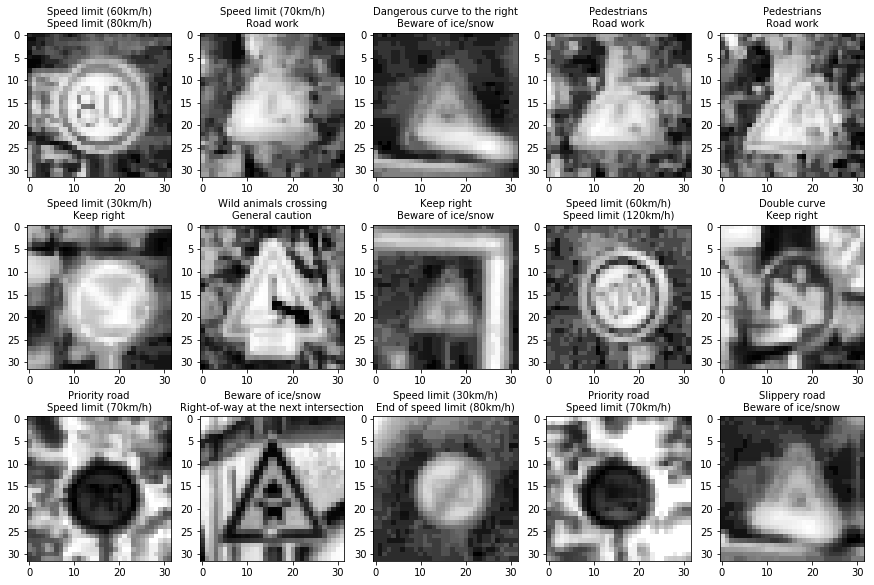

In [29]:
cond = (y_pred_test!=y_test)

fig = plt.figure(figsize = (15, 10))
for i, image in enumerate(X_test_pre[cond][:15]):
    img = image.reshape((32, 32))
    ax = fig.add_subplot(3, 5, i + 1)
    title = sign_names[y_pred_test[cond][i]] + '\n' + sign_names[y_test[cond][i]]
    ax.set_title(title, fontsize=10)
    plt.imshow(img, cmap='gray') 
plt.show()

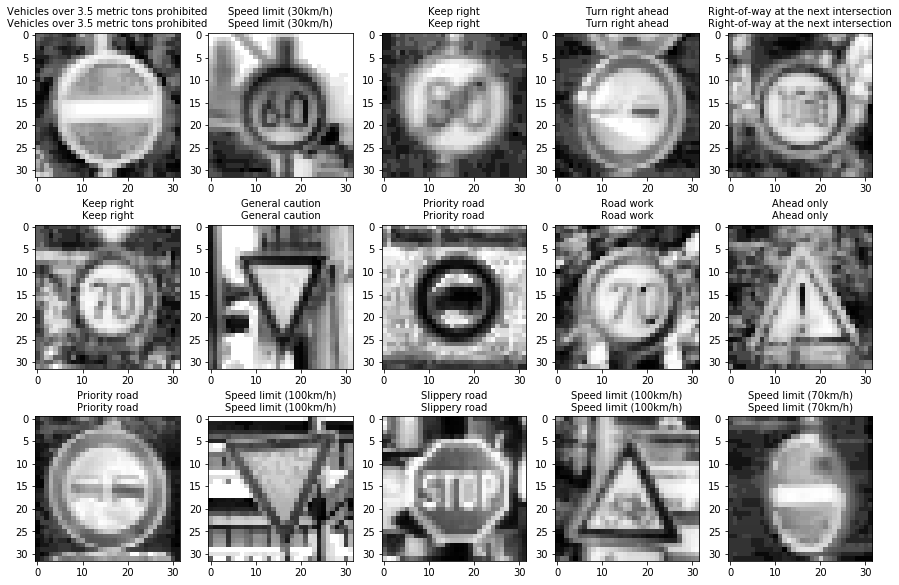

In [30]:
cond = (y_pred_test==y_test)

fig = plt.figure(figsize = (15, 10))
for i, image in enumerate(X_test_pre[cond][150:165]):
    img = image.reshape((32, 32))
    ax = fig.add_subplot(3, 5, i + 1)
    title = sign_names[y_pred_test[cond][i]] + '\n' + sign_names[y_test[cond][i]]
    ax.set_title(title, fontsize=10)
    plt.imshow(img, cmap='gray') 
plt.show()

Some of misclassfied images are even difficult to classify for a human. It is not surprising that the model has problems to classify them correctly. They are hidden behind other object and they are small and blury. It is possible that the chosen preprocessing technique is not optimal (i.e. histogram equalization) and could be improved.

## 4. Test a Model on New Images

We downloaded five test images from the web  displaying German traffic signs. In a first step we have to resize the images to 32x32x3. Then we preprocess them in the same way as the original images provided by Udacity. The five images are displayed in the next figure. Four of them are clearly visible and not partially hidden behind other objects. Furthermore brightness and size are convenient. Those images should be an easy task for our classifier. On the other the fifth image displays actually two traffic signs: *Roundabout mandatory* and *General caution*. It is interesting to see how the model copes with this situation. Ideally it should assign high probabilities to both classes.

The actual predictions of our model are shown directly above each image. The traffic signs *Road work*, *Stop* and *Bumpy road* were correctly classified. Surprisingly the predictions for *Roundabout mandatory* and the image with two traffic signs were in both cases *Priority road*. It might be related to the fact that the traffic sign *Priority road*  also has a thick stroke which resemebles to some degree the sign for *Roundabout mandatory*.

The accuracy of the model on these five test images is 60%.

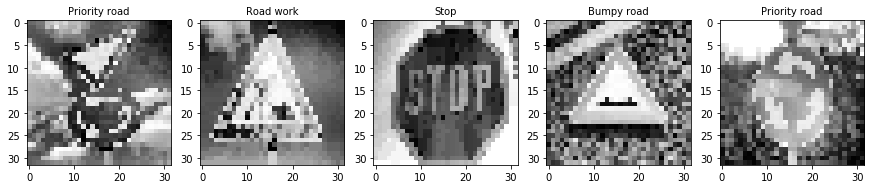

In [31]:
import glob
import matplotlib.image as mpimg

images_five = [mpimg.imread(image) for image in glob.glob("images/new_images_*.jpg")]
images_five = np.array([transform.resize(image, (32, 32, 3), mode='reflect') for image in images_five])
images_five = images_five*255
images_five = images_five.astype(np.uint8)
images_five = pre_process(images_five)

images_five_pred_perc = dnn_clf_uniform.predict_proba(images_five)
images_five_pred = np.argsort(images_five_pred_perc*(-1))[:,:5]


fig = plt.figure(figsize = (15, 10))
for i, image in enumerate(images_five):
    img = image.reshape((32, 32))
    ax = fig.add_subplot(3, 5, i + 1)
    ax.set_title(sign_names[images_five_pred[i][0]], fontsize=10)
    plt.imshow(img, cmap='gray') 
plt.show()

Further insights can be obtained by inspecting the probabilities the model assigned to each prediction. The next table shows - for each of the five images - the five classes with highest probability. In case of the three correctly predicted images the model was very sure about its predictions with probabilities larger than 90%. 

The model failed on the image with two traffic signs and was very sure about *Priority road* with 88.6%. At leat *Roundabout mandatory* appears with 3.4% on third position. *General caution* isn't part of the top five.

The model was not sure about its prediction on the *Roundabout mandatory* image. It assigned a probability of 46.6% to *Priority road*. The correct *Roundabout mandatory* appears on third position with 17.5%.

In [32]:
for img_idx in range(len(images_five_pred)):
    print('--------------------------------------------------')
    for cl in images_five_pred[img_idx]:
        print("{:40} {}".format(sign_names[cl], round(images_five_pred_perc[img_idx, cl]*100, 3)))

--------------------------------------------------
Priority road                            88.622
Speed limit (50km/h)                     3.616
Roundabout mandatory                     3.42
Speed limit (60km/h)                     1.635
Keep right                               1.142
--------------------------------------------------
Road work                                93.178
Beware of ice/snow                       5.528
Dangerous curve to the right             0.704
Slippery road                            0.325
Right-of-way at the next intersection    0.252
--------------------------------------------------
Stop                                     99.999
Keep right                               0.001
No vehicles                              0.0
Speed limit (60km/h)                     0.0
Traffic signals                          0.0
--------------------------------------------------
Bumpy road                               99.932
Slippery road                            0.068


## 5. Conclusion

We developed a model based on CNN-layers which is able to classify 97.04% of the instances of the test set and 98.93% of the validation set correctly. Although we used a data set 10 times larger than the original training set the model suffers from overfitting. Possible improvements are
* increase the size of the data set even further (20 or 30 times the size of the original training set)
* investigate precision and recall of each class to better understand how the model performs and how it can be improved
* use additional augmentation techniques e.g. change of perspective
* check if parameters of histogram equalization were not chosen correctly for pre-processing the data set

Nevertheless the requierments of Udacity with at least 93% accuracy were clearly met.